In [1]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import random 
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches

def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)

In [2]:
#Making list of chromosomes to process
chromToDo = []
for i in range(1,39):
    chrom = 'chr' + str(i)
    chromToDo.append(chrom)

In [147]:
#Root results directory
resultsDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/'

In [4]:
def read_xpclr_file():
    #For keeping track of data
    totalData = []
    scores, count = [], 0
    totalGrids,infCounts,failed_SNPZero,failed_SNPMin = 0, 0, 0, 0

    for line in inFile:
        line=line.rstrip().split(' ')
        if 'chrom' in line[0]:#skips header
            continue
        chrom = 'chr' + line[0]
        #processing line for more data
        gridNum, snpCount = int(line[1]),int(line[2])
        physical_pos,genetic_pos,max_s = round(float(line[3])),float(line[4]),float(line[6])
        XPCLR_score = line[5]
        totalGrids+=1
        #keeping track of certain data points
        if 'inf' in XPCLR_score:
            infCounts+=1
            continue
        if snpCount < 1:
            failed_SNPZero += 1
            continue
        if snpCount < 5:
            failed_SNPMin += 1
            continue
        XPCLR_score=float(line[5])
        scores.append(XPCLR_score)
        totalData.append([chrom,gridNum,snpCount,physical_pos,genetic_pos,XPCLR_score,max_s])
        #Writing this information to a bedfile
        bedFile.write('%s\t%s\t%s\t%s_%s\n' % (chrom,physical_pos-1,physical_pos,chrom,count))
    inFile.close()
    ################################################################
    print('%s grids were processed by XP-CLR' % ((totalGrids)))
    print('##EXCLUSIONS')
    print('%s of the grids had scores equal to infinity and were excluded until we determine what that means (failure??)' % infCounts)
    print('%s of the grids had no SNPs and were removed' % failed_SNPZero)
    print('%s of the grids had fewer than 5 SNPs and were removed' % failed_SNPMin)
    print('##FOR PROCESSING')
    print('%s of the grids remained for further processing after passing filtrations' % len(totalData))
    
    return totalData
#########################################################################################
def basic_stats(totalData):
    #Save full MAF array into a pandas dataframe
    df = pd.DataFrame(totalData,columns=['Chromosome','Grid','SNPCount','GenPos','cMPos','Score','MaxScore'])
    df.head()

    scoreMed = df['Score'].median()
    scoreMean = df['Score'].mean()
    scoreMax = df['Score'].max()
    print ('Median XP-CLR Score is', scoreMed)
    print ('Mean XP-CLR Score is ', scoreMean)
    print ('Max XP-CLR Score is ', scoreMax)

    pct99, pct995, pct999 = np.percentile(df['Score'], 99), np.percentile(df['Score'], 99.5), np.percentile(df['Score'], 99.9)
    print('##SIGNIFICANCE CUT-OFFS\n99th percentile of XP-CLR scores == ', pct99)
    print('99.5th percentile of XP-CLR scores == ', pct995)
    print('99.9th percentile of XP-CLR scores == ', pct999)
    return df, pct99, pct995, scoreMax
######################################################################################################
def draw_hist(plotFile, pct99):
    fig, axs = plt.subplots(1,2, figsize=(15, 5)) #Set up subplots for below distributions

    #Graph 1 = Score Distribution
    df['Score'].plot(ax=axs[0],kind='hist', bins=350,xlim=(0,50),alpha=0.75, normed = True)
    ax = axs[0]
    ax.set_xlabel('XP-CLR Score')
    ax.set_title('All Chromosomes - XP-CLR Score Distribution')
    ax.vlines(x=pct99,ymin=0,ymax=0.4, lw=1,color="red")

    #Graph 2 = SNP Count Distribution
    df['SNPCount'].plot(ax=axs[1],kind='hist', bins=75,alpha=0.75, normed = True, color="darkorange")
    ax = axs[1]
    ax.set_xlabel('XP-CLR SNP Count')
    ax.set_title('All Chromosomes - Per Grid SNP Counts')
    avg_SNPCount = df['SNPCount'].mean()
    ax.vlines(x=avg_SNPCount,ymin=0,ymax=0.1, lw=1,color="red")

    plt.savefig(plotFile) #Saving plots
##############################################################################################################
def draw_Manhattan_Plot(totalData,scoreMax):
    df = pd.DataFrame(totalData,columns=['Chromosome','Grid','SNPCount','GenPos','cMPos','Score','MaxScore'])
    df.Chromosome = df.Chromosome.astype('category')
    df.Chromosome = df.Chromosome.cat.set_categories(chromToDo, ordered=True)
    df = df.sort_values('Chromosome')

    df.head()
    # How to plot gene vs. -log10(pvalue) and colour it by chromosome?
    df['ind'] = range(len(df))
    df_grouped = df.groupby(('Chromosome'))

    ###PLOTTING MANHATTAN PLOT 
    #plotDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/plots/'
    fig = plt.figure(figsize=(24,12))
    ax = fig.add_subplot(111)
    x_labels, x_labels_pos, colors = [], [], ['black','gray']
    for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='Score',color=colors[num % len(colors)], ax=ax)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    #Xaxis
    ax.set_xlim([0, len(df)])
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels, fontsize=16)
    ax.set_xlabel('Chromosome',fontsize=20)
    #Yaxis
    ax.set_ylim([0, scoreMax+10])
    ax.set_ylabel('XP-CLR Score',fontsize=20)
    #Tick label sizes
    plt.tick_params(axis='both', which='major', labelsize=16)
    fig.tight_layout(rect=[0,0,.8,1]) 
    plt.hlines(y=pct995,xmin=0,xmax=len(df), lw=1,color="red", label="99.5th Sig Level")
    legend = ax.legend(loc='upper right', shadow=False,prop={'size': 20})
    plt.title(subDir.replace('_',' ') + ' XP-CLR Scores',fontsize=30)
    plt.savefig(plotDir + subDir + '_50kbWindow_2kbGridSize' + '_XP-CLR.png')
##############################################################################################################

In [5]:
def find_sig_windows(sigThreshold, totalData):
    print('\n#SIGNIFICANT WINDOWS\nSignificance threshold is XP-CLR = ', sigThreshold)
    sigHits = []

    for i in range(0,len(totalData)):
        chrom, score = totalData[i][0], round(float(totalData[i][5]),3)
        if score > sigThreshold:
            sigHits.append(totalData[i])
    print('%i significant windows found from XP-CLR'%(len(sigHits)))
    return sigHits

chromList, count, sigCount = [], 0, -1
CHROM, WINDOW, SCORE = 0, 0, 0
mergedWindows = {}
##############################################################################################################
def merge_sig_windows(sigHits):
    sigCount = 0
    print('\n#MERGED WINDOWS')
    chromList = []
    for i in range(0,len(sigHits)):
        chrom, num, pos, score = sigHits[i][0], sigHits[i][1], round(sigHits[i][3]),float(sigHits[i][5])
        start, end = pos-25000, pos+25000 #start/end of the sliding window is 25kb from either side of this grid point
        winID  = chrom + '_' + str(num)

        #keeping track of chromosomes analyzed, helps save information automatically for first call on a chromosome
        #   for further comparisons with the next call
        if chrom not in chromList:
            chromList.append(chrom)
            CHROM, NUM, START,END,SCORE = chrom, num, start, end, score
            sigCount += 1
            mergedWindows[sigCount] = []
            mergedWindows[sigCount].append([CHROM, NUM, START, END, SCORE])
            #print('FIRST',chrom, num, pos, start, end, score)
            continue
        #processing calls
        if CHROM == chrom and num - NUM < 2: #can only have one window between them
            #print('YES',chrom, num, pos, start, end, score)
            CHROM, NUM, START,END,SCORE = chrom, num, start, end, score
            mergedWindows[sigCount].append([CHROM, NUM, START, END, SCORE])
            CHROM, NUM, START,END = chrom, num, start, end

        else:
            #print('NO',chrom, num, pos, start, end, score)
            sigCount += 1
            CHROM, NUM, START,END,SCORE = chrom, num, start, end, score
            mergedWindows[sigCount] = []
            mergedWindows[sigCount].append([CHROM, NUM, START, END, SCORE])

        CHROM, NUM, START,END,SCORE = chrom, num, start, end, score

    print('%i merged windows found to be significant' % sigCount)
    return mergedWindows
##############################################################################################################
def filter_merged_windows(mergedWindows):
    print('\n#FILTER MERGED WINDOWS')
    merged3Windows, count = [], 0

    for i in mergedWindows:
        if len(mergedWindows[i]) < 3:
            continue
        count += 1 #keeping track of how many merged windows with at least 3 sig windows are present
        chrom, start = mergedWindows[i][0][0], mergedWindows[i][0][2] #chrom and start can be defined by the first indexed window in the list
        scores = []
        for j in mergedWindows[i]:
            end = j[3] #end will always be the last window read through the loop, constantly overwriting
            scores.append(j[4]) #to keep track of for calculating the average score
        meanScore = format(round(np.mean(scores),3)) #formats and rounds the average scores per merged window
        winLength = end - start
        ID = 'XP-CLR_' + str(count) 
        merged3Windows.append([chrom,start,end,ID,winLength,meanScore]) #now save all the information

    print('%i windows contained three or more adjacent windows and were merged' % count) 
    return merged3Windows

################################################################################################

In [6]:
#In/Out files
subDir = 'Dogs_v_Wolves'
print('\n### %s ####\n' % subDir)
infile = resultsDir + 'No_MAF_Filter/' + 'Window50kb_GridSize2kb/' + subDir + '/Merged_VillageWolf_XPCLR_CM_window50kb_gridSize2kb.xpclr.txt'
inFile = open(infile,'r')
bedfile = infile.replace('.txt','.bed')
bedFile = open(bedfile,'w')

totalData = read_xpclr_file()
df, pct99, pct995, scoreMax = basic_stats(totalData)

#Draw score distributions
#plotDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/No_MAF_Filter/plots/'
"""plotDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/No_MAF_Filter/plots/'
plotFile = plotDir + 'Dogs_v_Wolves_Score_SNPCount_Distributions_50kbWindow_2kbGridSize' + '_XP-CLR.png'
draw_hist(plotFile, pct99)
draw_Manhattan_Plot(totalData,scoreMax)"""

#Find significant hits
sigThreshold = round(float(pct995),3)
sigHits = find_sig_windows(sigThreshold, totalData)
mergedWindows = merge_sig_windows(sigHits)
merged3Windows = filter_merged_windows(mergedWindows)
###############################
#Writing out
outfile = resultsDir + 'No_MAF_Filter/' + 'Window50kb_GridSize2kb/' + subDir + '/SignificantWindows/' +  'Merged_SignificantWindows_DogvsWolf_XP-CLR_50kbWindow_2kbGrid.txt'
outFile = open(outfile,'w')
for i in range(0,len(merged3Windows)):
    #print('\t'.join(map(str,merged3Windows[i])) + '\n')
    outFile.write('\t'.join(map(str,merged3Windows[i])) + '\n')
outFile.close()
###############################



### Dogs_v_Wolves ####

1113366 grids were processed by XP-CLR
##EXCLUSIONS
779625 of the grids had scores equal to infinity and were excluded until we determine what that means (failure??)
49037 of the grids had no SNPs and were removed
66546 of the grids had fewer than 5 SNPs and were removed
##FOR PROCESSING
218158 of the grids remained for further processing after passing filtrations
Median XP-CLR Score is 2.9009
Mean XP-CLR Score is  6.679060329935187
Max XP-CLR Score is  265.810643
##SIGNIFICANCE CUT-OFFS
99th percentile of XP-CLR scores ==  49.20810758
99.5th percentile of XP-CLR scores ==  60.827677425
99.9th percentile of XP-CLR scores ==  97.590640092

#SIGNIFICANT WINDOWS
Significance threshold is XP-CLR =  60.828
1091 significant windows found from XP-CLR

#MERGED WINDOWS
564 merged windows found to be significant

#FILTER MERGED WINDOWS
103 windows contained three or more adjacent windows and were merged


In [118]:
##############################################################################################
def find_gene_pos():
    #GTF file with genes of interest:
    gtfFile = open('/home/ampend/links/kidd-lab/ampend-projects/BLAST2GO/ensembl_input/Canis_familiaris.CanFam3.1.81.gtf','r')
    #YOU NEED TO DO THIS BY HAND BY GREP'ING THE GTF FILE:
    genesOfInterest, genePos = [], []
    for line in gtfFile:
        if '#' in line:
            continue
        line=line.rstrip().split('\t')
        if 'exon' not in line[2]:
            continue
        chrom, start, end, direction = 'chr' + line[0], int(line[3]), int(line[4]), str(line[6])
        if chrom == ROIchrom:
            if start >= ROIstart and end <= ROIend:
                geneInfo = line[8]  #Finding gene ID in line
                if 'gene_name' in geneInfo:
                    geneInfo = geneInfo.split(';')
                    geneInfo = geneInfo[5].split(' ')
                    geneID = geneInfo[2].replace('"','')
                else:
                    geneInfo = geneInfo.split(';')
                    geneInfo = geneInfo[0].split(' ')
                    geneID = geneInfo[1].replace('"','')
                if 'ENSCAFG00000028653' in geneID:
                    geneID = 'AMY2B'
                if geneID not in genesOfInterest:
                    genesOfInterest.append(geneID)
                genePos.append([geneID,start,end,direction])
            else:
                continue
        else:
            continue
    gtfFile.close()
    return genesOfInterest,genePos
###################################################################
def get_xpclr_score(totalData,ROIchrom,ROIstart,ROIend):
    ##LONG## 
    dataArray, index = [], -1
    for window in totalData:
        chrom,midpoint,start, end, score = window[0], int(window[3]), int(window[3])-25000, int(window[3])+25000, float(window[5])
        #Now check if the call is within the ROI
        if chrom == ROIchrom and start >= ROIstart and end <= ROIend:
            dataArray.append([chrom,midpoint,score])
    return dataArray
###################################################################
def get_fst():
    #Per Site, Total callset
    perTotal = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Total_54callset_MxbRemoved/PerSite/Merged_VillageWolf_mxb_rm_PERSITE_54callset_AutoXParXNonPar_Hudson_Fst_PerSite_Zscores.txt'
    fileArray = []
    fileArray.append(perTotal)

    index=-1
    perSiteArray, SlideArray, NoSlideArray = [] , [], []
    for file in fileArray:
        index += 1
        inFile = open(file,'r')
        for line in inFile:
            if 'Chrom' in line or 'CHROM' in line:
                continue
            line = line.rstrip().split('\t')
            if 'PerSite' in file:
                chrom,start,end,Z = line[0],int(line[1]),int(line[1]),float(line[3])
            else:
                chrom,start,end, Z = line[0],int(line[1]),int(line[2]),float(line[9])
            #Now check if the call is within the ROI
            if chrom == ROIchrom and start >= ROIstart and end <= ROIend:
                if '50kbSlide' in file: #OVERLAP WINDOW FILE
                    midpoint = float(start + end)/2
                    SlideArray.append([chrom,midpoint,Z])
                    continue
                if 'PerSite' in file: #PER SITE WINDOW FILE
                    perSiteArray.append([chrom,start,Z])
                    continue
                else: #NO OVERLAP WINDOW FILE
                    midpoint = float(start + end)/2
                    NoSlideArray.append([chrom,midpoint,Z])
                    continue                
    return perSiteArray, SlideArray, NoSlideArray
###################################################################
def simpleaxis(ax): #takes away the right and top borders/axes of a plot or subplot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
###################################################################

/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


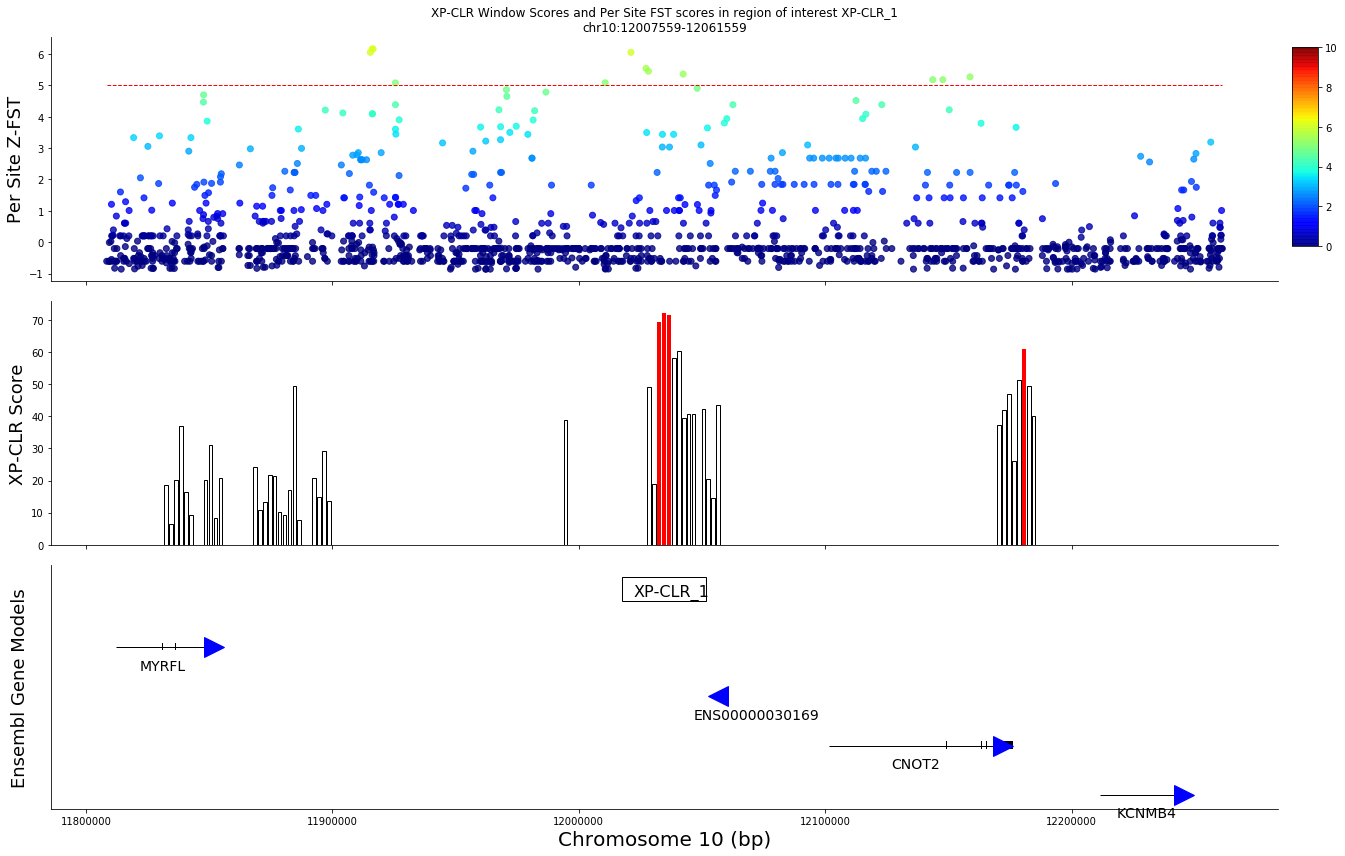

In [172]:
#def draw_plot(ROIchrom,ROI_CDR,dataArray, coord, plotFile):
#Three subplots, the axes array is 1-d
f, axarr = plt.subplots(3, sharex=True, figsize=(18,12))

####PLOT 1 - Per Site SNP Fst
x, y = [], []
for i in range(0,len(perSiteArray)):
    x.append(perSiteArray[i][1])
    y.append(perSiteArray[i][2])
colors=y
sc = axarr[0].scatter(x, y,c=colors, cmap=color_map, vmin=0, vmax=10, alpha=0.8)
axarr[0].set_title('XP-CLR Window Scores and Per Site FST scores in region of interest %s\n%s' % (ROI_CDR,coord))
simpleaxis(axarr[0])
axarr[0].set_ylabel('Per Site Z-FST', fontsize =18)
axarr[0].hlines(y=5, xmin=np.min(x), xmax=np.max(x),lw=1,color="red",linestyles='dashed')
#Add color bar
f.subplots_adjust(right=1.8)
cbar_ax = f.add_axes([1.0, 0.71, 0.02, 0.23])
f.colorbar(sc, cax=cbar_ax)

####PLOT 2- XP-CLR Scores
for i in range(0,len(dataArray)):
    x, y, width = dataArray[i][1], dataArray[i][2], 1500
    scoreList.append(dataArray[i][2])
    if y > pct995:
        axarr[1].bar(x, y, width, color="red",linewidth=1)
    else:
        axarr[1].bar(x, y, width, color="black",fill=False,linewidth=1)
simpleaxis(axarr[1])
axarr[1].set_ylabel('XP-CLR Score', fontsize=18)

####PLOT 3 - GENE MODELS
#Add CDR  ROI window
CDR = [ROIstart+210000,ROIend-210000]
axarr[2].add_patch(patches.Rectangle((CDR[0], -2),(CDR[1]-CDR[0]),0.5,fill=None))
axarr[2].text(((ROIstart+ROIend)/2-12500), -1.9,str(ROI_CDR),fontsize=16)

IDheights, geneheights, index, heights =[-2.5,-3.5,-4.5,-5.5,-6.5,-7.5], [-3,-4,-5,-6,-7,-8], -1, []
for gene in genesOfInterest:
    xRange = []
    #determines height to print the genes and gene IDs
    if index == 5:
        index = 0
    else:
        index += 1
    for i in range(0,len(genePos)):
        if gene == genePos[i][0]:
            x, direction, length = genePos[i][1], genePos[i][3], genePos[i][2]-genePos[i][1]
            axarr[2].add_patch(patches.Rectangle((x,geneheights[index]),length,0.15,facecolor="black"))
            xRange.append(x)
    xMin, xMax = min(xRange), max(xRange)
    if direction == '-':
        axarr[2].plot(xMin-0.25, geneheights[index]+0.06, marker='<',color="blue",markersize=20)
    if direction == '+':
        axarr[2].plot(xMax+0.25, geneheights[index]+0.06, marker='>',color="blue",markersize=20)
    axarr[2].hlines(y=geneheights[index]+0.06, xmin=xMin, xmax=xMax,lw=1,color="black")
    if 'ENSCAFG' in gene:#ADDING GENE TEXT
        gene = gene.replace('ENSCAFG','ENS')
    geneMidpoint = ((xMax+xMin)/2)-10000
    if geneMidpoint < ROIend-10000: #Make sure the gene ID doesn't get printed off the plot
        axarr[2].text(geneMidpoint,geneheights[index]-0.4,gene,fontsize=14)
    heights.append(geneheights[index])
yMax=(np.min(heights))-1.4
#axarr[2].set_ylim(-1.75,yMax)
axarr[2].axes.get_yaxis().set_ticks([])
simpleaxis(axarr[2])
axarr[2].set_ylabel('Ensembl Gene Models', fontsize=18, labelpad=22)
axarr[2].set_xlabel('Chromosome %s (bp)' % (ROIchrom.replace('chr','')) , fontsize=20) #rotate yaxis label and move over from axis ticks
axarr[2].ticklabel_format(useOffset=False,style='plain',fontsize=18)#turn off sci-notation in  xaxis labelling


#Draw plot
plt.tight_layout()
plt.savefig(plotFile)


#XP-CLR_1
Looking for the Fst information for these coordinates: chr10 11807559 12261559

Genes of Interest in Region of Interest:
 ['MYRFL', 'ENSCAFG00000030169', 'CNOT2', 'KCNMB4']
47 windows found within the region of interest (XP-CLR_1)
1400 per site FST values in the region of interest (XP-CLR_1)


/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


DONE!


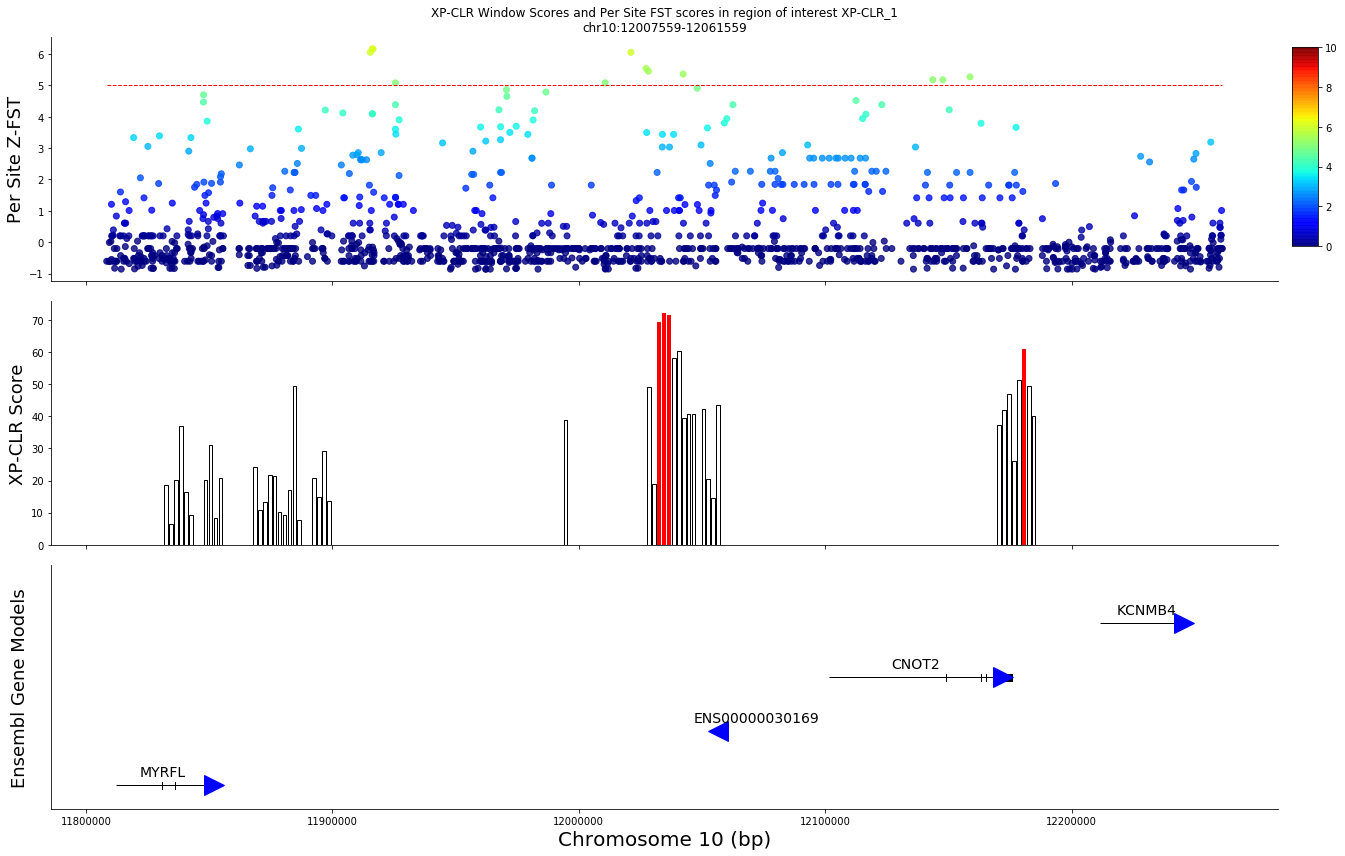

In [154]:
#Plotting individual merged, significant windows (with at least 3 windows)
for i in range(0,len(merged3Windows)):
    if 'chr18' not in ROIchrom:
        continue
    ROIchrom, ROIstart, ROIend, ROI_CDR = merged3Windows[i][0],int(merged3Windows[i][1]),int(merged3Windows[i][2]),merged3Windows[i][3]
    print('#%s' % ROI_CDR)
    coord = ROIchrom + ':' + str(ROIstart) + '-' + str(ROIend)
    ROIstart, ROIend = ROIstart - 200000, ROIend + 200000
    print ('Looking for the Fst information for these coordinates:',ROIchrom,ROIstart,ROIend)
    #Finding genes in the region
    genesOfInterest,genePos = find_gene_pos()

    print ('\nGenes of Interest in Region of Interest:\n', genesOfInterest)

    dataArray = get_xpclr_score(totalData,ROIchrom,ROIstart,ROIend)
    print('%i windows found within the region of interest (%s)' % (len(dataArray),ROI_CDR))
    perSiteArray, SlideArray, NoSlideArray = get_fst()
    print('%i per site FST values in the region of interest (%s)' % (len(perSiteArray),ROI_CDR) )
    
    #Draw per window plots
    plotFile = resultsDir + 'No_MAF_Filter/' + 'Window50kb_GridSize2kb/' + subDir + '/SignificantWindows/' + ROI_CDR + '_LocusPlot.png'
    draw_plot(ROIchrom, ROI_CDR, dataArray, coord, plotFile)
    break
print('DONE!')  
    

43980047.5 -3.1
44234664.5 -4.1


ValueError: Invalid RGBA argument: -0.628830926636641

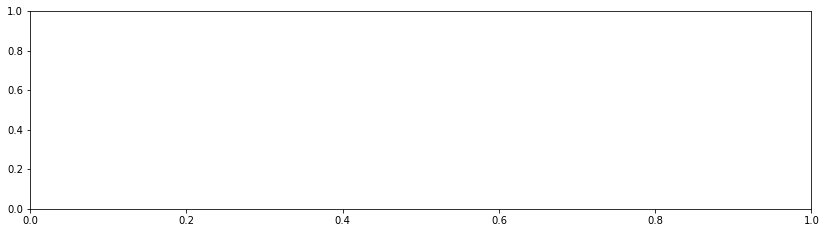

In [41]:
from matplotlib.colors import LinearSegmentedColormap

cmap = plt.get_cmap('jet')
start, stop = 0, 1
colors = cmap(np.linspace(start, stop, cmap.N))
# Create a new colormap from those colors
color_map = LinearSegmentedColormap.from_list('Upper Half', colors)

fig = plt.figure(figsize=(14,8))
ax1 = plt.subplot(111)
#PLOTTING PER SITE Fst SNPs
x, y = [], []
for i in range(0,len(perSiteArray)):
    x.append(perSiteArray[i][1])
    y.append(perSiteArray[i][2])
colors=y
sc = ax1.scatter(x, y,c=colors, cmap=color_map, vmin=0, vmax=10, alpha=0.4)
ax1.set_ylabel('Fst Z-Score', fontsize=18)
ax1.set_ylim(0,10)
ax1.axes.get_yaxis().set_ticks([0,2,4,6,8,10])
        
                    
"""position=fig.add_axes([.97, .26, .05, 0.52])
cb = fig.colorbar(sc, cax=position, drawedges=False)
cb.set_label('FST Z-Score', fontsize=14)"""
########################################################
scoreList = []
ax2 = ax1.twinx()
#PLOTTING XP-CLR SLIDING WINDOWS
for i in range(0,len(dataArray)):
    x, y, width = dataArray[i][1], dataArray[i][2], 1500
    scoreList.append(dataArray[i][2])
    if y > pct995:
        ax2.bar(x, y, width, color="red",linewidth=1)
    else:
        ax2.bar(x, y, width, color="black",fill=False,linewidth=1)
maxScore = np.max(scoreList)
#Y-Axis #2
ax2.set_ylim(0,maxScore + (.1*maxScore)) 
ax2.set_ylabel('XP-CLR Score', fontsize=18, rotation=270, labelpad=20) #rotate yaxis label and move over from axis ticks
ax2.axes.get_yaxis().set_ticks([0,20,40,60,80,100])
#X-axis
ax2.ticklabel_format(useOffset=False,style='plain')#turn off sci-notation in  xaxis labelling
ax2.set_xlabel('Chromosome' , fontsize=18) #rotate yaxis label and move over from axis ticks
########################################################
ax3 = ax1.twinx()
#DRAWING GENE MODELS
IDheights, geneheights, index =[-2.5,-3.5,-4.5,-5.5,-6.5,-7.5], [-3,-4,-5,-6,-7,-8], -1
for gene in genesOfInterest:
    xRange = []
    #determines height to print the genes and gene IDs
    if index == 5:
        index = 0
    else:
        index += 1
    for i in range(0,len(genePos)):
        if gene == genePos[i][0]:
            x, direction, length = genePos[i][1], genePos[i][3], genePos[i][2]-genePos[i][1]
            ax3.add_patch(patches.Rectangle((x,geneheights[index]),length,0.75,facecolor="black"))
            xRange.append(x)
    xMin, xMax = min(xRange), max(xRange)
    if direction == '-':
        ax3.plot(xMin-0.25, geneheights[index]+0.1, marker='<',color="blue")
    if direction == '+':
        ax3.plot(xMax+0.25, geneheights[index]+0.1, marker='>',color="blue")
    ax3.hlines(y=geneheights[index]+0.1, xmin=xMin, xmax=xMax,lw=1,color="black")
    if 'ENSCAFG' in gene:#ADDING GENE TEXT
        gene = gene.replace('ENSCAFG','ENS')
    geneMidpoint = ((xMax+xMin)/2)-10000
    if geneMidpoint < ROIend-10000: #Make sure the gene ID doesn't get printed off the plot
        #ax.text(xMax+2500,geneheights[index]+0.3,gene,fontsize=7)
        print (geneMidpoint,geneheights[index]-0.1)
        ax3.text(geneMidpoint,geneheights[index]-0.1,gene,fontsize=7)
ax3.axes.get_yaxis().set_ticks([])

#plt.title('XP-CLR Window Scores and Per Site FST scores in region of interest %s\n%s' % (ROI_CDR,coord))
#plt.show()

plt.subplot(212)
sc = ax1.scatter(x, y,c=colors, cmap=color_map, vmin=0, vmax=10, alpha=0.4)


In [247]:
#############################################################################
#def draw_plot(ROIchrom,ROI_CDR,dataArray,pct995, coord):
    fig, ax1 = plt.subplots(1,1,figsize=(14,8))

    #plotArray, barColor = determine_sig(NoSlideArray,SlideArray)
    #PLOT LIMITS
    yMaximum = 9
    yMinimum = -9
    ax1.ticklabel_format(useOffset=False,style='plain')#turn off sci-notation in  xaxis labelling

    #PLOTTING PER SITE Fst SNPs
    x, y = [], []
    for i in range(0,len(perSiteArray)):
        x.append(perSiteArray[i][1])
        y.append(perSiteArray[i][2])
    colors=y
    ax1.scatter(x, y ,c=colors, cmap=plt.cm.gist_earth, alpha=0.3)
    ax1.set_ylabel('Fst Z-Score', fontsize=18)
    #ax2.set_ylim(-4,10)

    scoreList = []
    ax2 = ax1.twinx()
    #PLOTTING XP-CLR SLIDING WINDOWS
    for i in range(0,len(dataArray)):
        x, y, width = dataArray[i][1], dataArray[i][2], 1500
        scoreList.append(dataArray[i][2])
        if y > pct995:
            ax2.bar(x, y, width, color="red",linewidth=1)
        else:
            ax2.bar(x, y, width, color="black",fill=False,linewidth=1)
    maxScore = np.max(scoreList)
    ax2.set_ylim(-4,maxScore + (.1*maxScore)) 
    ax2.set_ylabel('XP-CLR Score', fontsize=18, rotation=270, labelpad=20) #rotate yaxis label and move over from axis ticks
    ax2.ticklabel_format(useOffset=False,style='plain')#turn off sci-notation in  xaxis labelling


    plt.title('XP-CLR Window Scores and Per Site FST scores in region of interest %s (%s)' % (ROI_CDR, coord))
    
    
    
    plt.show()

'#ADDING TITLES\nplt.xlabel(\'Chromosome %s Position\' % (ROIchrom.replace("chr","")),fontsize=20)\nplt.ylabel(r\'$ZF_{ST}$\',fontsize=20)\nplt.title(\'Per Site and Window ZFst for %s\' % ROI_CDR)\n#Add CDR window\nCDR = [ROIstart+210000,ROIend-210000]\nif \'CDR20\' in ROI_CDR:\n    CDR = [ROIstart+100000,ROIend-100000]\nax.add_patch(patches.Rectangle((CDR[0], -1.75),(CDR[1]-CDR[0]),0.5,fill=None))\nax.text(((ROIstart+ROIend)/2-10000), -1.7,str(ROI_CDR))\nax.ticklabel_format(useOffset=False,style=\'plain\')#turn off sci-notation in  xaxis labelling\n#plt.savefig(plotDir + ROI_CDR + \'Locus_ZFstPlotWithGeneModels.png\')'

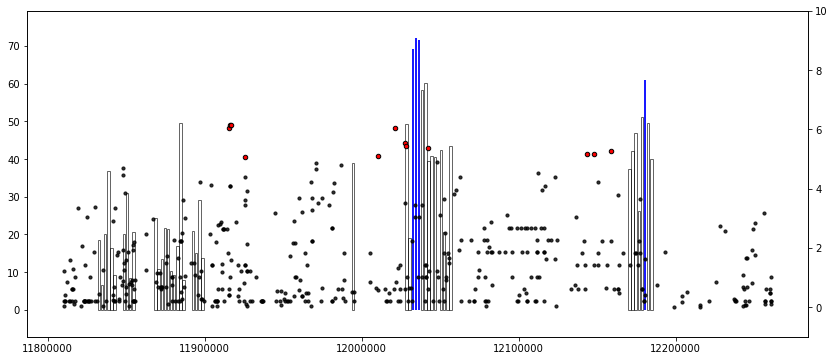

In [234]:
#############################################################################
#def draw_plot(ROIchrom,ROI_CDR,dataArray,pct995):
fig, ax1 = plt.subplots(1,1,figsize=(14,6))

#plotArray, barColor = determine_sig(NoSlideArray,SlideArray)
#PLOT LIMITS
yMaximum = 9
yMinimum = -9
ax1.ticklabel_format(useOffset=False,style='plain')#turn off sci-notation in  xaxis labelling

scoreList = []
#PLOTTING XP-CLR SLIDING WINDOWS
for i in range(0,len(dataArray)):
    x, y, width = dataArray[i][1], dataArray[i][2], 1500
    scoreList.append(dataArray[i][2])
    if y > pct995:
        ax1.bar(x, y, width, color="blue",alpha=0.9,linewidth=1)
    else:
        plt.bar(x, y, width, fill=False,alpha=0.6,linewidth=1)
maxScore = np.max(scoreList)
ax1.set_ylim(-(.1*maxScore),maxScore + (.1*maxScore))

#PLOTTING PER SITE Fst SNPs
ax2 = ax1.twinx()
for i in range(0,len(perSiteArray)):
    x,y =perSiteArray[i][1],perSiteArray[i][2]
    if y > 5:
        ax2.scatter(x,y,facecolor='red',edgecolor='k',s=20)
    if y < 5 and y > 0:
        ax2.scatter(x,y,color='black',alpha=0.8,s=10)
ax2.set_ylim(-(10*.1),10)
#DEFINING AXIS LIMS
#plt.ylim(yMinimum,yMaximum+0.5)
#plt.xlim(ROIstart,ROIend)
#ax = plt.axes()

"""
ax3 = ax1.twinx()

#DRAwING GENE MODELS
###mp = []
IDheights=[-3.5,-4.5,-5.5,-6.5,-7.5,-8.5]
geneheights=[-3,-4,-5,-6,-7,-8]
index = -1
for gene in genesOfInterest:
    xRange = []
    #determines height to print the genes and gene IDs
    if index == 5:
        index = 0
    else:
        index += 1
    for i in range(0,len(genePos)):
        if gene == genePos[i][0]:
            x = genePos[i][1]
            direction = genePos[i][3]
            length = genePos[i][2]-genePos[i][1]
            #ax.add_patch(patches.Rectangle((x, -3),length,0.75,facecolor="black"))
            ax3.add_patch(patches.Rectangle((x,geneheights[index]),length,0.75,facecolor="black"))
            xRange.append(x)
    xMin,xMax = min(xRange),max(xRange)
    if direction == '-':
        ax3.plot(xMin-0.25, geneheights[index]+0.4, marker='<',color="blue")
    if direction == '+':
        ax3.plot(xMax+0.25, geneheights[index]+0.4, marker='>',color="blue")
    ax3.hlines(y=geneheights[index]+0.4, xmin=xMin, xmax=xMax,lw=1,color="black")
    #ADDING GENE TEXT
    if 'ENSCAFG' in gene:
        gene = gene.replace('ENSCAFG','ENS')
    geneMidpoint = ((xMax+xMin)/2)-10000
    if geneMidpoint < ROIend-10000: #Make sure the gene ID doesn't get printed off the plot
        #ax.text(xMax+2500,geneheights[index]+0.3,gene,fontsize=7)
        print (geneMidpoint,geneheights[index]-0.4)
        ax3.text(geneMidpoint,geneheights[index]-0.4,gene,fontsize=7)"""

        
"""#ADDING TITLES
plt.xlabel('Chromosome %s Position' % (ROIchrom.replace("chr","")),fontsize=20)
plt.ylabel(r'$ZF_{ST}$',fontsize=20)
plt.title('Per Site and Window ZFst for %s' % ROI_CDR)
#Add CDR window
CDR = [ROIstart+210000,ROIend-210000]
if 'CDR20' in ROI_CDR:
    CDR = [ROIstart+100000,ROIend-100000]
ax.add_patch(patches.Rectangle((CDR[0], -1.75),(CDR[1]-CDR[0]),0.5,fill=None))
ax.text(((ROIstart+ROIend)/2-10000), -1.7,str(ROI_CDR))
ax.ticklabel_format(useOffset=False,style='plain')#turn off sci-notation in  xaxis labelling
#plt.savefig(plotDir + ROI_CDR + 'Locus_ZFstPlotWithGeneModels.png')"""
#############################################################################

In [295]:
#In/Out files
subDir = 'Wolves_v_Dogs'
print('\n### %s ####\n' % subDir)
infile = resultsDir + 'No_MAF_Filter/' + 'Window50kb_GridSize2kb/' + subDir + '/Merged_WolfVillage_XPCLR_CM_window50kb_gridSize2kb.xpclr.txt'
inFile = open(infile,'r')
bedfile = infile.replace('.txt','.bed')
bedFile = open(bedfile,'w')

#For keeping track of data
totalData = []
scores,chromProcessed = [], []
totalGrids,infCounts,failed_SNPZero,failed_SNPMin = 0, 0, 0, 0

for line in inFile:
    line=line.rstrip().split(' ')
    if 'chrom' in line[0]:#skips header
        continue
    chrom = 'chr' + line[0]
    #Naming the sweep is based on chromosome and the window number on that chromosome
    if chrom in chromProcessed:
        count += 1
    else:
        chromProcessed.append(chrom)
        count = 1
    #processing line for more data
    gridNum, snpCount = int(line[1]),int(line[2])
    physical_pos,genetic_pos,max_s = round(float(line[3])),float(line[4]),float(line[6])
    XPCLR_score = line[5]
    totalGrids+=1
    #keeping track of certain data points
    if 'inf' in XPCLR_score:
        infCounts+=1
        continue
    if snpCount < 1:
        failed_SNPZero += 1
        continue
    if snpCount < 5:
        failed_SNPMin += 1
        continue
    XPCLR_score=float(line[5])
    scores.append(XPCLR_score)
    totalData.append([chrom,gridNum,snpCount,physical_pos,genetic_pos,XPCLR_score,max_s])
    #Writing this information to a bedfile
    bedFile.write('%s\t%s\t%s\t%s_%s\n' % (chrom,physical_pos-1,physical_pos,chrom,count))
inFile.close()
################################################################
print('%s grids were processed by XP-CLR' % ((totalGrids)))
print('##EXCLUSIONS')
print('%s of the grids had scores equal to infinity and were excluded until we determine what that means (failure??)' % infCounts)
print('%s of the grids had no SNPs and were removed' % failed_SNPZero)
print('%s of the grids had fewer than 5 SNPs and were removed' % failed_SNPMin)
print('##FOR PROCESSING')
print('%s of the grids remained for further processing after passing filtrations' % len(totalData))


### Wolves_v_Dogs ####

1101423 grids were processed by XP-CLR
##EXCLUSIONS
627668 of the grids had scores equal to infinity and were excluded until we determine what that means (failure??)
51309 of the grids had no SNPs and were removed
72387 of the grids had fewer than 5 SNPs and were removed
##FOR PROCESSING
350059 of the grids remained for further processing after passing filtrations


In [296]:
###COMPARE WITH FST/VST sweeps
print('\n### %s ####\n' % subDir)

cdrfile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Merged_Final_CDRs_VCDRs/Total_CDR_VCDR.bed'
bedOut = resultsDir + 'No_MAF_Filter/' + 'Window50kb_GridSize2kb/' + subDir + '/Intersect_With_CDR_VCDR.txt'

cmd = 'bedtools intersect -a %s -b %s > %s' % (cdrfile,bedfile,bedOut)
runCMD(cmd)
print(cmd)


### Wolves_v_Dogs ####

bedtools intersect -a /home/ampend/links/kidd-lab/ampend-projects/Angela/Merged_Final_CDRs_VCDRs/Total_CDR_VCDR.bed -b /home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/No_MAF_Filter/Window50kb_GridSize2kb/Wolves_v_Dogs/Merged_WolfVillage_XPCLR_CM_window50kb_gridSize2kb.xpclr.bed > /home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/No_MAF_Filter/Window50kb_GridSize2kb/Wolves_v_Dogs/Intersect_With_CDR_VCDR.txt


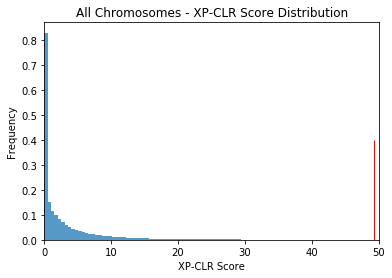

In [297]:
#Save full MAF array into a pandas dataframe
df = pd.DataFrame(totalData,columns=['Chromosome','Grid','SNPCount','GenPos','cMPos','Score','MaxScore'])
df.head()

################################################
myPlot = df['Score'].plot(kind='hist', bins=350,xlim=(0,50),alpha=0.75, normed = True)
myPlot.set_xlabel('XP-CLR Score')
myPlot.set_title('All Chromosomes - XP-CLR Score Distribution')
plt.vlines(x=pct99,ymin=0,ymax=0.4, lw=1,color="red")


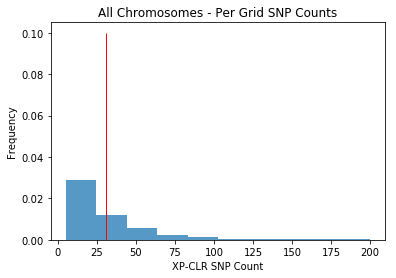

In [298]:

################################################
myPlot = df['SNPCount'].plot(kind='hist', bins=10,alpha=0.75, normed = True)
myPlot.set_xlabel('XP-CLR SNP Count')
myPlot.set_title('All Chromosomes - Per Grid SNP Counts')
avg_SNPCount = df['SNPCount'].mean()
plt.vlines(x=avg_SNPCount,ymin=0,ymax=0.1, lw=1,color="red")


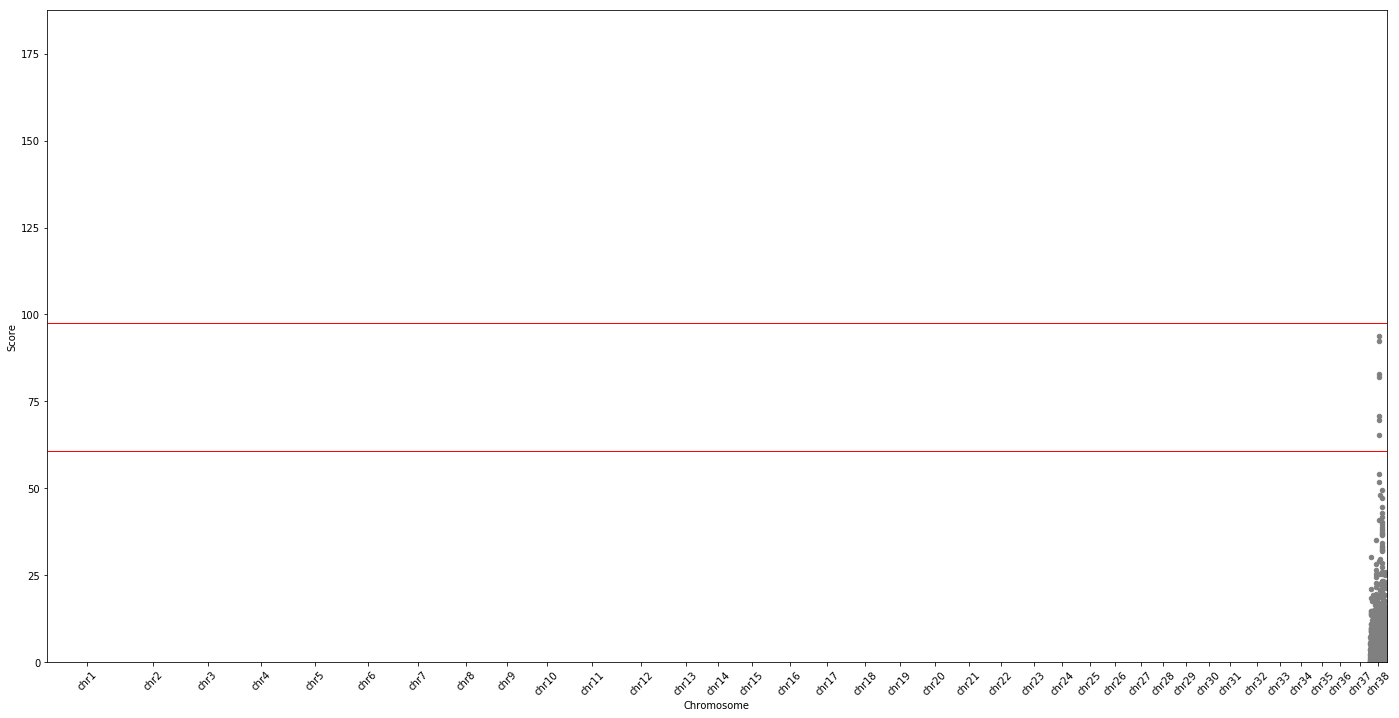

In [300]:
df = pd.DataFrame(totalData,columns=['Chromosome','Grid','SNPCount','GenPos','cMPos','Score','MaxScore'])
df.Chromosome = df.Chromosome.astype('category')
df.Chromosome = df.Chromosome.cat.set_categories(chromToDo, ordered=True)
df = df.sort_values('Chromosome')

df.head()
# How to plot gene vs. -log10(pvalue) and colour it by chromosome?
df['ind'] = range(len(df))
df_grouped = df.groupby(('Chromosome'))

###PLOTTING MANHATTAN PLOT 
plotDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/No_MAF_Filter/Window50kb_GridSize2kb/plots'
fig = plt.figure(figsize=(24,12))
ax = fig.add_subplot(111)
colors = ['black','gray']
x_labels = []
x_labels_pos = []
for num, (name, group) in enumerate(df_grouped):
    group.plot(kind='scatter', x='ind', y='Score',color=colors[num % len(colors)], ax=ax)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
plt.hlines(y=pct995,xmin=0,xmax=len(df), lw=1,color="red")
plt.hlines(y=pct999,xmin=0,xmax=len(df), lw=1,color="red")
ax.set_xlim([0, len(df)])
ax.set_ylim([0, np.max(scores)+10])
ax.set_xlabel('Chromosome')
#plt.savefig(plotDir + 'Wolves_v_Dogs_50kbWindow_2kbGridSize' + '_XP-CLR.png')


In [141]:
print('######  Wolves versus Dogs ######')
sigThreshold = round(float(pct995),3)
print(sigThreshold)

sigHits = []

for i in range(0,len(totalData)):
    chrom, score = totalData[i][0], round(float(totalData[i][5]),3)
    if score > sigThreshold:
        sigHits.append(totalData[i])
print('%i significant windows found from XP-CLR'%(len(sigHits)))

######  Wolves versus Dogs ######
60.828
1043 significant windows found from XP-CLR


In [175]:
chromList, count, sigCount = [], 0, -1
CHROM, WINDOW, SCORE = 0, 0, 0
mergedWindows = {}

for i in range(0,len(sigHits)):
    chrom, num, pos, score = sigHits[i][0], sigHits[i][1], round(sigHits[i][3]),float(sigHits[i][5])
    start, end = pos-25000, pos+25000 #start/end of the sliding window is 25kb from either side of this grid point
    winID, count = chrom + '_' + str(num), count +1
    
    #keeping track of chromosomes analyzed, helps save information automatically for first call on a chromosome
    #   for further comparisons with the next call
    if chrom not in chromList:
        chromList.append(chrom)
        CHROM, NUM, START,END,SCORE = chrom, num, start, end, score
        sigCount += 1
        mergedWindows[sigCount] = []
        mergedWindows[sigCount].append([CHROM, NUM, START, END, SCORE])
        #print('FIRST',chrom, num, pos, start, end, score)
        continue
    #processing calls
    if CHROM == chrom and num - NUM < 2: #can only have one window between them
        #print('YES',chrom, num, pos, start, end, score)
        CHROM, NUM, START,END,SCORE = chrom, num, start, end, score
        mergedWindows[sigCount].append([CHROM, NUM, START, END, SCORE])
        CHROM, NUM, START,END = chrom, num, start, end

    else:
        #print('NO',chrom, num, pos, start, end, score)
        sigCount += 1
        CHROM, NUM, START,END,SCORE = chrom, num, start, end, score
        mergedWindows[sigCount] = []
        mergedWindows[sigCount].append([CHROM, NUM, START, END, SCORE])
        
    CHROM, NUM, START,END,SCORE = chrom, num, start, end, score

print('%i merged windows found to be significant' % sigCount)

349 merged windows found to be significant


In [186]:
#def filter_merged_windows(mergedWindows):
merged3Windows, count = [], 0

for i in mergedWindows:
    if len(mergedWindows[i]) < 3:
        continue
    count += 1 #keeping track of how many merged windows with at least 3 sig windows are present
    chrom, start = mergedWindows[i][0][0], mergedWindows[i][0][2] #chrom and start can be defined by the first indexed window in the list
    scores = []
    for j in mergedWindows[i]:
        end = j[3] #end will always be the last window read through the loop, constantly overwriting
        scores.append(j[4]) #to keep track of for calculating the average score
    meanScore = format(round(np.mean(scores),3)) #formats and rounds the average scores per merged window
    winLength = end - start
    ID = 
    merged3Windows.append([chrom,start,end,ID,winLength,meanScore]) #now save all the information


print('%i windows contained three or more adjacent windows and were merged' % count)  

98 windows contained three or more adjacent windows and were merged


In [189]:
outfile = resultsDir + 'No_MAF_Filter/' + 'Window50kb_GridSize2kb/' + subDir + '/SignificantWindows/' +  'Merged_SignificantWindows_WolfvsDog_XP-CLR_50kbWindow_2kbGrid.txt'
outFile = open(outfile,'w')


for i in range(0,len(merged3Windows)):
    #print('\t'.join(map(str,merged3Windows[i])) + '\n')
    outFile.write('\t'.join(map(str,merged3Windows[i])) + '\n')

outFile.close()